<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.RwandaCO2Emissions/blob/main/0_baseline_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [10]:
from google.colab import drive

# Datasets
import pandas as pd

# Import module files

In [3]:
%%capture

def download(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}


GIT_URL = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
download(
    {
        file: GIT_URL + file
        for file in [
            'path_manager.py'
        ]
    }
)

In [4]:
import path_manager
import importlib

def reload_all(modules_list):
    for m in modules_list:
        importlib.reload(m)

from path_manager import PathManager

# Mount the drive and setup paths

In [13]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive'

COMPETITION_PATH = f'{gdrive_path}/ML/Competitions/8.CO2Emissions'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1

manager = PathManager(
    COMPETITION_PATH,
    PREPROC_TRIAL,
    MODELS_TRIAL
)

manager.setup_paths()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ML/Competitions/8.CO2Emissions/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/8.CO2Emissions/Models/trial_1 already exists


# Download the data

In [14]:
train = pd.read_csv(manager.train_path)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [15]:
train.describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023.000000,79023.000000,79023.000000,79023.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,...,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,79023.000000
mean,-1.891072,29.880155,2020.000000,26.000000,0.000048,0.834848,0.000035,0.158418,-7.925870,37.436189,...,5592.377478,59420.297456,4670.430869,19.139241,0.271460,-10.784832,40.436976,-86.800583,27.925981,81.940552
std,0.694522,0.810375,0.816502,15.297155,0.000272,0.185382,0.000206,0.071364,64.263368,14.149950,...,1428.503002,9051.163609,1359.251583,13.547047,0.049434,30.374462,6.428216,37.837269,4.403835,144.299648
min,-3.299000,28.228000,2019.000000,0.000000,-0.000996,0.241822,-0.000887,0.000000,-179.537059,0.099237,...,1050.661782,24779.033704,1050.496816,1.844529,0.017697,-102.739731,2.998873,-153.464211,10.818288,0.000000
25%,-2.451000,29.262000,2019.000000,13.000000,-0.000096,0.705817,-0.000078,0.110535,-56.782383,28.844520,...,4595.400519,53175.779928,3680.856344,9.974574,0.241453,-30.309170,35.829907,-125.991158,24.686763,9.797995
50%,-1.882000,29.883000,2020.000000,26.000000,0.000024,0.809118,0.000019,0.161855,-12.441726,37.784299,...,5573.854309,59332.532548,4621.755170,15.130688,0.272747,-12.673914,41.119630,-84.644352,28.333630,45.593445
75%,-1.303000,30.471000,2021.000000,39.000000,0.000153,0.942792,0.000121,0.211824,72.059990,47.634875,...,6542.303642,65663.842684,5572.983223,23.785030,0.302892,9.402202,44.446272,-48.132701,31.499883,109.549595
max,-0.510000,31.532000,2021.000000,52.000000,0.004191,1.885239,0.004236,0.299998,122.095200,66.242012,...,12384.239458,89291.615576,11384.239458,250.000000,0.736514,78.223037,65.951248,-22.653170,42.060436,3167.768000


# Quick look at the data

In [17]:
train.shape

(79023, 76)

In [18]:
train.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

<Axes: >

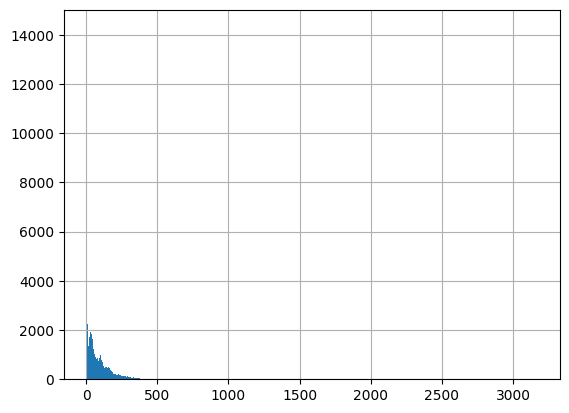

In [20]:
train['emission'].hist(bins=1000)

In [21]:
train['emission'].describe()

count    79023.000000
mean        81.940552
std        144.299648
min          0.000000
25%          9.797995
50%         45.593445
75%        109.549595
max       3167.768000
Name: emission, dtype: float64

# Data cleaning

## Remove outliers in the target

<Axes: >

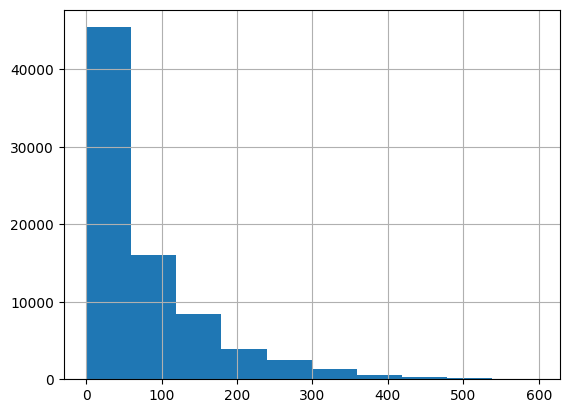

In [25]:
train[
    train['emission'] <= 600
]['emission'].hist()

In [29]:
train[train['emission'] > 600].shape[0] / train.shape[0]

0.004175999392581907

In [32]:
print(train.shape)

THRESHOLD = 600
train = train.loc[
    train['emission'] < THRESHOLD,
    :
]

print(train.shape)

(79023, 76)
(78693, 76)


<Axes: >

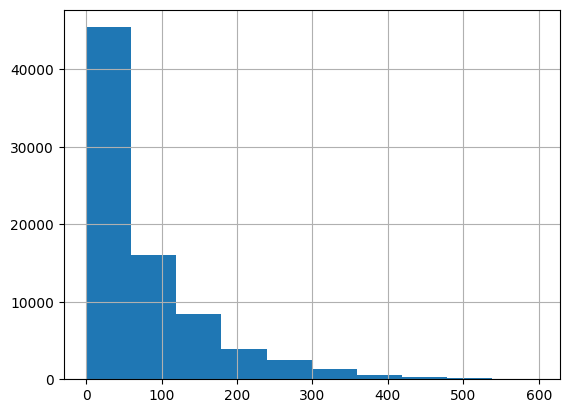

In [33]:
train['emission'].hist()

In [36]:
# All the types are numeric, except for one
train.dtypes

ID_LAT_LON_YEAR_WEEK           object
latitude                      float64
longitude                     float64
year                            int64
week_no                         int64
                               ...   
Cloud_sensor_azimuth_angle    float64
Cloud_sensor_zenith_angle     float64
Cloud_solar_azimuth_angle     float64
Cloud_solar_zenith_angle      float64
emission                      float64
Length: 76, dtype: object

In [45]:
if 'ID_LAT_LON_YEAR_WEEK' in train.columns:
    train.drop(['ID_LAT_LON_YEAR_WEEK'], axis='columns', inplace=True)
assert 'ID_LAT_LON_YEAR_WEEK' not in train.columns

## Clean columns with high nan percentage

In [52]:
NAN_PERCENTAGE = 0.2

columns_to_remove = []
for c in train.columns:
    n_nans = train[c].isna().sum()
    nan_percent = n_nans / train.shape[0]
    if nan_percent >= NAN_PERCENTAGE:
        columns_to_remove.append(c)

print(train.shape)
train.drop(columns_to_remove, axis='columns', inplace=True)
print(train.shape)

(78693, 75)


<ipython-input-52-8d2821fca3ef>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns_to_remove, axis='columns', inplace=True)


(78693, 56)